Label Mapping:
{'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}
Running Elbow Method...


C:\Users\User\Desktop\facultate\master\an1\BDA\BDA_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\User\Desktop\facultate\master\an1\BDA\BDA_Project\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec

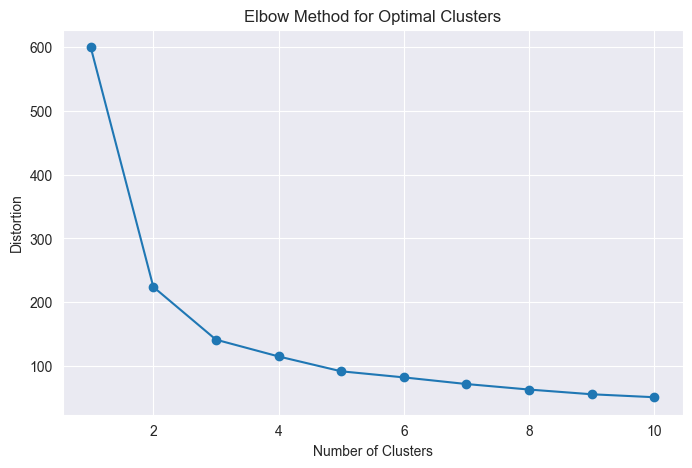

Running K-Means with 3 clusters...
Aligned Cluster Labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Aligned Centroids: [[-1.01457897  0.84230679 -1.30487835 -1.25512862]
 [-0.05021989 -0.88029181  0.34753171  0.28206327]
 [ 1.13597027  0.09659843  0.996271    1.01717187]]
Visualizing initial K-Means clustering...


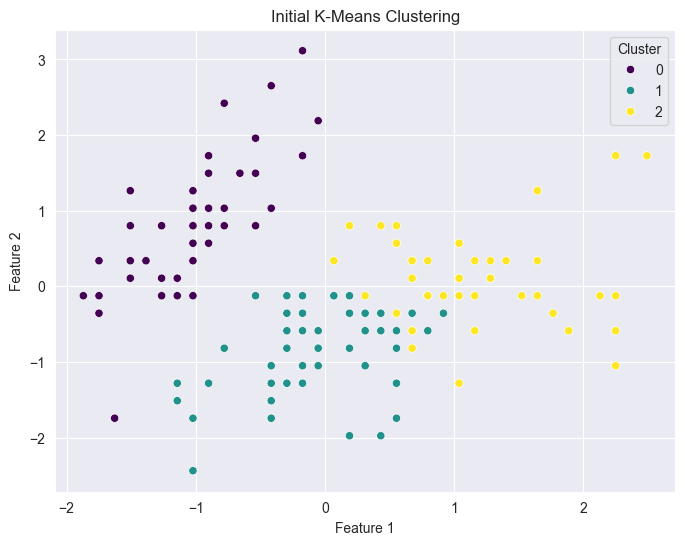

K-Means Metrics: {'precision': 0.8339355011374281, 'recall': 0.8333333333333334, 'accuracy': 0.8333333333333334}


In [1]:
import numpy as np
import pandas as pd

from code.clustering import run_kmeans, elbow_method, align_labels_and_centroids
from code.utils import load_data, plot_clusters, calculate_metrics

# Experiment with Iris Dataset

data_path = "../data/Iris-150.txt"
data, encoded_labels, label_mapping = load_data(data_path)

# Assign original_labels for metric calculations
original_labels: np.ndarray = encoded_labels  # Use the numeric-encoded labels for calculations

print("Label Mapping:")
print(label_mapping)

# Elbow method to find optimal clusters
print("Running Elbow Method...")
elbow_method(data)

# Run K-Means clustering
optimal_clusters = 3  # Replace with optimal number determined from elbow plot
print(f"Running K-Means with {optimal_clusters} clusters...")
kmeans_model, cluster_labels = run_kmeans(data, optimal_clusters)
centroids = kmeans_model.cluster_centers_

# Align cluster labels and centroids
cluster_labels, centroids = align_labels_and_centroids(
    true_labels=original_labels,
    cluster_labels=cluster_labels,
    centroids=centroids
)

# Verify the alignment
print("Aligned Cluster Labels (first 10):", cluster_labels[:10])
print("Aligned Centroids:", centroids)
# Plot initial K-Means clustering results
print("Visualizing initial K-Means clustering...")
plot_clusters(data, cluster_labels, "Initial K-Means Clustering", "../results/iris/initial_kmeans.png")
# Calculate K-Means metrics
kmeans_metrics = calculate_metrics(original_labels, cluster_labels)
print(f"K-Means Metrics: {kmeans_metrics}")
# Convert cluster_labels to pd.Series for compatibility
cluster_labels = pd.Series(cluster_labels, index=data.index)

Evaluating Split Criterion (SC)...
Evaluating threshold: 0.4 (Method: sc)...
Evaluating threshold: 0.45 (Method: sc)...
Evaluating threshold: 0.5 (Method: sc)...
Evaluating threshold: 0.55 (Method: sc)...
Evaluating threshold: 0.6 (Method: sc)...
Evaluating threshold: 0.65 (Method: sc)...
Evaluating threshold: 0.7 (Method: sc)...
Evaluating threshold: 0.8 (Method: sc)...
Evaluating Silhouette Scores...
Evaluating threshold: 0.2 (Method: silhouette)...
Evaluating threshold: 0.4 (Method: silhouette)...
Evaluating threshold: 0.45 (Method: silhouette)...
Evaluating threshold: 0.5 (Method: silhouette)...
Evaluating threshold: 0.55 (Method: silhouette)...
Evaluating threshold: 0.6 (Method: silhouette)...
Evaluating threshold: 0.65 (Method: silhouette)...
Evaluating threshold: 0.7 (Method: silhouette)...


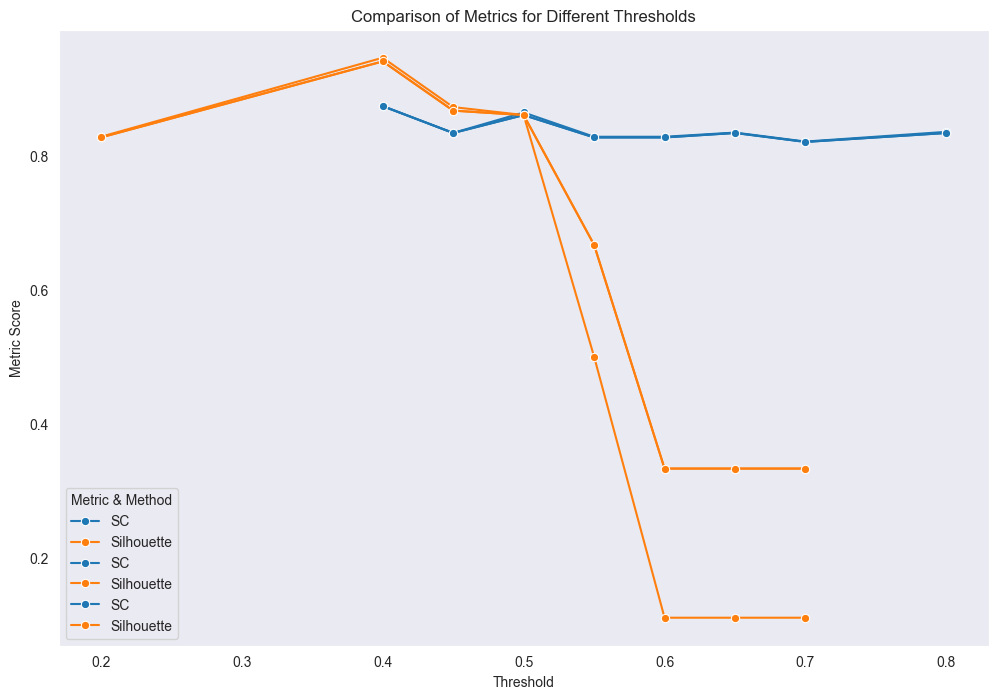

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from code.post_processing import split_stable_and_misclassified, detect_misclassified_with_silhouette, \
    post_process_with_rf
from code.utils import calculate_metrics


# Function to run post-processing with different thresholds
def evaluate_thresholds(data, labels, centroids, original_labels, thresholds, method="sc"):
    """
    Evaluate metrics for different thresholds using SC or silhouette scores.

    Args:
        data (pd.DataFrame): Features.
        labels (np.ndarray): Cluster labels from KMeans.
        centroids (np.ndarray): Cluster centroids.
        original_labels (np.ndarray): True labels for evaluation.
        thresholds (list): List of threshold values to evaluate.
        method (str): "sc" for Split Criterion, "silhouette" for silhouette score.

    Returns:
        pd.DataFrame: DataFrame with metrics for each threshold.
    """
    results = []

    for threshold in thresholds:
        print(f"Evaluating threshold: {threshold} (Method: {method})...")

        # Split stable and misclassified points based on the method
        if method == "sc":
            stable_data, stable_labels, misclassified_data, misclassified_labels = split_stable_and_misclassified(
                data, labels, centroids, threshold=threshold
            )
        elif method == "silhouette":
            stable_data, stable_labels, misclassified_data, misclassified_labels = detect_misclassified_with_silhouette(
                data, labels, threshold=threshold
            )
        else:
            raise ValueError("Invalid method. Use 'sc' or 'silhouette'.")

        # Reclassify misclassified points using Random Forest
        if not misclassified_data.empty:
            updated_labels = post_process_with_rf(
                stable_data, stable_labels,
                misclassified_data,
            )
            misclassified_labels.update(pd.Series(updated_labels, index=misclassified_data.index))

            # Combine stable and reclassified labels
            combined_labels = pd.concat([stable_labels, misclassified_labels]).sort_index()

            # Calculate metrics against original labels
            metrics = calculate_metrics(original_labels, combined_labels)
            metrics["threshold"] = threshold
            results.append(metrics)
        else:
            print("Misclassified data was empty")

    return pd.DataFrame(results)


print("Evaluating Split Criterion (SC)...")
sc_results = evaluate_thresholds(
    data, cluster_labels, centroids, original_labels,
    thresholds=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8],
    method="sc"
)

print("Evaluating Silhouette Scores...")
silhouette_results = evaluate_thresholds(
    data, cluster_labels, centroids, original_labels,
    thresholds=[0.2, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7],
    method="silhouette"
)

# Combine results for plotting
sc_results["Method"] = "SC"
silhouette_results["Method"] = "Silhouette"
all_results = pd.concat([sc_results, silhouette_results])

# Plot the metrics comparison
plt.figure(figsize=(12, 8))
sns.lineplot(data=all_results, x="threshold", y="accuracy", hue="Method", marker="o")
sns.lineplot(data=all_results, x="threshold", y="precision", hue="Method", marker="o")
sns.lineplot(data=all_results, x="threshold", y="recall", hue="Method", marker="o")
plt.title("Comparison of Metrics for Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.legend(title="Metric & Method")
plt.grid()
plt.savefig("../results/iris/threshold_comparisons.png")
plt.show()
